In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from jmd95 import eos
import datetime
import xray
import pandas as pd
from scipy.ndimage import gaussian_filter1d

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'
plt.rcParams['figure.figsize'] = (16,8)


bmap = brewer2mpl.get_map('Set1', 'Qualitative', 6)
plt.rcParams['axes.color_cycle'] = bmap.mpl_colors


In [2]:
ds_surf = xray.open_dataset('../data/wmt_surface.nc')
ds_mixing = xray.open_dataset('../data/wmt_upper_0671m.nc')
ds = ds_surf.merge(ds_mixing)
ds = ds / 1e6 # convert to Sverdrups

In [3]:
# there are two treatments of the heat flux
# one (ds.heat_flux) does not properly account for shortwave penetration
# drop it and replace with the correct version
ds = ds.drop('heat_flux')
ds['heat_flux'] = ds.heat_surfflux + ds.heat_sw

In [4]:
# add neutral density

# original from TS diagram
#sig_vs_gam = np.load('sigma_vs_gamma.npz')
#gam = np.interp(ds.sigma0, sig_vs_gam['sigma0'][::-1], sig_vs_gam['gamman'][::-1])

# more accurate SOSE fit
sig_vs_gam = np.load('sigma_vs_gamma_SOSE_fit_upper670m.npz')
gam = np.interp(ds.sigma0, sig_vs_gam['sigma0'], sig_vs_gam['gamman'])

# add a little smoothing
gam = gaussian_filter1d(gam, 6)

ds['gamman'] = xray.DataArray(gam, dims=ds.sigma0.dims, coords=ds.sigma0.coords)
ds.set_coords('gamman', inplace=True)

<xray.Dataset>
Dimensions:          (sigma0: 399, time: 438)
Coordinates:
  * sigma0           (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 ...
  * time             (time) datetime64[ns] 2005-01-06T05:00:00 ...
    gamman           (sigma0) float64 25.83 25.83 25.83 25.83 25.83 25.83 ...
Data variables:
    heat_wthmass     (time, sigma0) float64 -0.07799 -0.03679 -0.07753 ...
    salt_IO_plus_AO  (time, sigma0) float64 -0.02287 -0.01476 -0.02551 ...
    salt_AI_plus_AO  (time, sigma0) float64 -0.02287 -0.01476 -0.02551 ...
    salt_AI          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_AO          (time, sigma0) float64 -0.02287 -0.01476 -0.02551 ...
    salt_IO          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_brine    (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_IO_melt     (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt_wsltmass    (time, sigma0) float64 0.5151 0.2485 0.4647 0.4

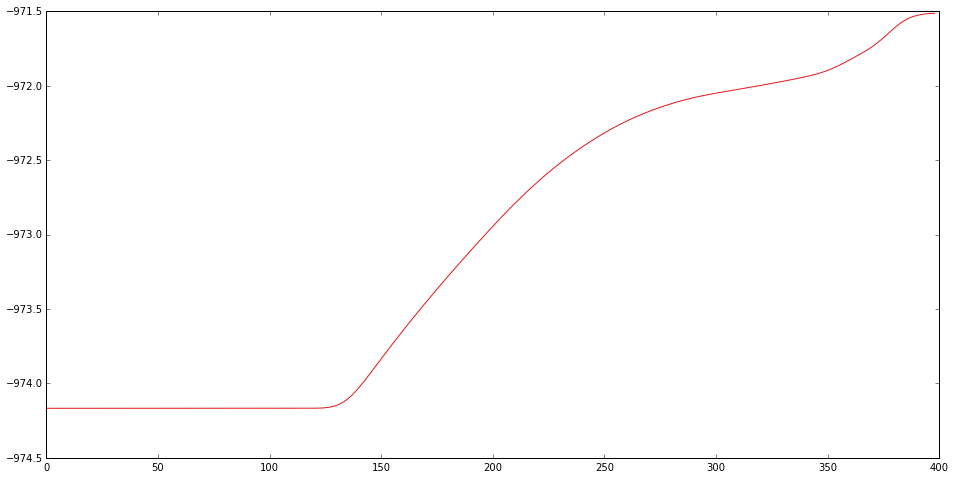

In [5]:
plt.plot(gam-1000)

In [6]:
# annual mean water mass transformation
wmt = ds.mean(dim='time') # values in sv
wmt_year = ds.groupby('time.year').mean(dim='time')

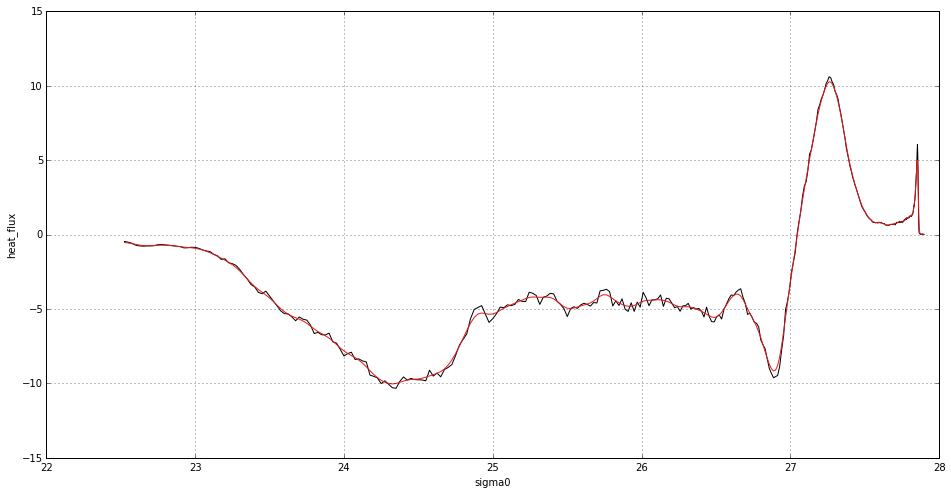

In [7]:
# smooth the transformation curves with a gaussian filter
wmt_sm = wmt.copy(deep=True)
FILTER_SIZE = 2
for k in wmt_sm.data_vars.keys():
    da = wmt_sm[k]
    da.data = gaussian_filter1d(da, FILTER_SIZE)
wmt.heat_flux.plot(color='k')
wmt_sm.heat_flux.plot()
plt.grid()

In [8]:
# make one version for sigma and one for gamma
wmt_sig0 = wmt_sm
wmt_gam = wmt_sm.swap_dims({'sigma0': 'gamman'})

In [9]:
# the "b factor"
sig0 = 1000 + ds.sigma0.values
gam = 1000 + ds.gamman.values

# second order centered difference
bfac = xray.DataArray(
        np.pad((gam[2:]-gam[:-2])/(sig0[2:]-sig0[:-2]), 1, mode='edge'),
        coords=wmt_gam.gamman.coords,
        dims=wmt_gam.gamman.dims
)

# this will multiply everything by the mysterious "b factor"
#wmt_gam = wmt_gam * bfac

In [10]:
# formation

def deriv_wrt_coord(wmt):
    """Take centered deriviative of a dataset for all variables."""
    # infer coordinate name from a variable
    cname = wmt.heat_flux.dims[0]
    coord = wmt[cname]
    # centered difference
    coord_mid_data = 0.5*(coord.data[1:] + coord.data[:-1])
    dcoord = (coord.data[1:] - coord.data[:-1])
    new_ds = xray.Dataset(coords={cname: (cname, coord_mid_data)})
    for k in wmt.data_vars.keys():
        new_ds[k] = -xray.DataArray(np.diff(wmt[k].data)/dcoord,
                                   coords={cname: coord_mid_data},
                                   dims=[cname,])
    new_ds['delta_' + cname] = xray.DataArray(dcoord,
                                   coords={cname: coord_mid_data},
                                   dims=[cname,])
    new_ds.set_coords('delta_' + cname, inplace=True)
    return new_ds

wmf_sig0 = deriv_wrt_coord(wmt_sig0)
wmf_gam = deriv_wrt_coord(wmt_gam)

# Transformation Rates #

In [11]:
# use neutral density for plots
#wmt_sm = wmt_sm.swap_dims({'sigma0': 'gamman'})

In [12]:
# sigma_0
wmass_names_sig0 = {'T/MW': 26.0, 'AAIW': 27.0, 'UCDW': 27.55, 'LCDW': 27.72, 'AABW': 27.82}

wmass_names_gam = ['TW', 'SAMW', 'AAIW', 'UCDW', 'LCDW', 'AABW']
wmass_vals_gam =[26.0,26.6,27.0,27.5,28.0,28.2,28.5]

#wmass_boundaries = [('T/MW', (26.0,27.0)), ('AAIW', (27.0,27.55)),
#                    ('UCDW', (27.55,27.72)), ('LCDW', (27.72, 27.82)),
#                    ('AABW', (27.82,29.))]

In [13]:
def base_figure(coord_name, coord_ticks, wmass_names, wmass_vals, ylim, label_pos):

    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.fontsize'] = 7
    plt.rcParams['lines.linewidth'] = 1.5
    plt.rcParams['font.size'] = 8
    fig = plt.figure(figsize=(6.5,3.0))
    fig.subplots_adjust(left=0.09, right=0.99, bottom=0.13, top=0.9)
    ax = fig.add_subplot(111)
    
    ax.set_xticks(coord_ticks, minor=False);
    ax.set_xticks(wmass_vals[:-1], minor=True);
    ax.set_yticks([0], minor=True)
    
    ax.grid()
    ax.xaxis.grid(False, which='major')
    #ax.xaxis.grid(True, which='minor')
    ax.xaxis.grid(False, which='minor')
    ax.yaxis.grid(False, which='major')
    ax.yaxis.grid(True, which='minor')

    for n, (name, dlow, dhigh) in enumerate(zip(wmass_names, wmass_vals[:-1], wmass_vals[1:])):
        ax.text((dlow+dhigh)/2, label_pos, name, color='0.5',
                ha='center', va='center', rotation='horizontal')
        #ax.text(dlow+0.02, label_pos, name, color='0.5',
        #        ha='left', va='bottom', rotation='vertical')
        if (n%2)!=0:
            ax.fill_between([dlow, dhigh], 2*(ylim[0],), 2*(ylim[1],),
                           edgecolor='none', facecolor='0.95')

    ax.set_xlim([coord_ticks[0],coord_ticks[-1]])
    ax.set_ylim(ylim)

    return fig, ax
            

def wmt_surface_plot(wmt, figure_fname, coord_name, coord_ticks,
                     wmass_names, wmass_vals,
                     ylim=[-35,20], xlim=[26,28.5], label_pos=18):

    fig, ax = base_figure(coord_name, coord_ticks, wmass_names, wmass_vals,
                          ylim, label_pos)

    mcols = bmap.mpl_colors
    #colors = bmap.mpl_colors[2:]

    # the three ice components
    wmt.salt_AO.plot(ax=ax, color=mcols[2])
    wmt.salt_IO_brine.plot(ax=ax, color=mcols[3])
    wmt.salt_IO_melt.plot(ax=ax, color=mcols[4])

    # redistribtuion
    wmt.salt_AI_plus_AO.plot(ls='--', color=mcols[2], ax=ax)
    redist = wmt.salt_IO - wmt.salt_AI
    redist.plot(ls='--', color=mcols[1], ax=ax)

    # direct precip
    wmt.salt_IO_plus_AO.plot(color=mcols[1])
    # heat flux
    wmt.heat_flux.plot(color=mcols[0], ax=ax)

    (wmt.salt_IO_plus_AO + wmt.heat_flux).plot(color='k', ax=ax)

    all_mixing = (wmt.salt_hdiff + wmt.salt_kpp + wmt.salt_vdiff +
              wmt.heat_hdiff + wmt.heat_kpp + wmt.heat_vdiff)
    (all_mixing + wmt.salt_IO_plus_AO + wmt.heat_flux
    ).plot(ax=ax, color='k', ls='--', linewidth=3)
    
    
    ax.legend(['E-P-R (to ocean)', 'brine rejection', 'ice melt',
                'E-P-R (from atm.)','FW redistribution', 'net FW flux',
               'net heat flux', 'total surface', 'surface + mixing'],
              loc='lower left')

    ax.set_title('Transformation Components')
    ax.set_ylabel('Sv')
    ax.set_xlabel(coord_name)
    ax.set_xlim(xlim)

    #plt.tight_layout()
    plt.savefig(figure_fname)

def wmt_mixing_plot(wmt, figure_fname, coord_name, coord_ticks,
                     wmass_names, wmass_vals,
                    ylim=[-12,12], xlim=[26,28.5], label_pos=11):

    fig, ax = base_figure(coord_name, coord_ticks, wmass_names, wmass_vals,
                          ylim, label_pos)
    mcols = bmap.mpl_colors
    
    wmt.heat_hdiff.plot(ax=ax, color=mcols[0], ls='--')
    (wmt.heat_kpp + wmt.heat_vdiff).plot(ax=ax, color=mcols[0], ls='-')
    wmt.salt_hdiff.plot(ax=ax, color=mcols[1], ls='--')
    (wmt.salt_kpp + wmt.salt_vdiff).plot(ax=ax, color=mcols[1], ls='-')

    all_mixing = (wmt.salt_hdiff + wmt.salt_kpp + wmt.salt_vdiff +
                  wmt.heat_hdiff + wmt.heat_kpp + wmt.heat_vdiff)

    all_mixing.plot(ax=ax, color='k')
    
    ax.legend(['heat horiz.', 'heat vert.', 'salt horiz.', 'salt vert.',
               'total mixing'], #, 'total (mixing + surface)'],
              loc='lower left')
    ax.set_title('Upper Ocean Mixing Transformation Components')
    ax.set_ylabel('Sv')
    ax.set_xlabel(coord_name)
    ax.set_xlim(xlim)

    
    #plt.tight_layout()
    plt.savefig(figure_fname)
    
    
def formation_plot(wmf, figure_fname, coord_name, coord_ticks,
                     wmass_names, wmass_vals,
                     ylim=[-80,80], xlim=[26,28.5], label_pos=72, ):
    
    fig, ax = base_figure(coord_name, coord_ticks, wmass_names, wmass_vals,
                          ylim, label_pos)
    mcols = bmap.mpl_colors
    
    wmf.salt_AO.plot(ax=ax, color=mcols[2])
    wmf.salt_IO.plot(ax=ax, color=mcols[3])
    #wmf.salt_IO_brine.plot(ax=ax, color=colors[1])
    #wmf.salt_IO_melt.plot(ax=ax, color=colors[2])

    wmf.heat_flux.plot(color=mcols[0], ax=ax)

    (wmf.salt_hdiff + wmf.salt_kpp + wmf.salt_vdiff + #).plot(ax=ax, color=mcols[1], ls=':')
    wmf.heat_hdiff + wmf.heat_kpp + wmf.heat_vdiff).plot(ax=ax, color=mcols[1], ls='--')

    (wmf.salt_hdiff + wmf.salt_kpp + wmf.salt_vdiff +
     wmf.heat_hdiff + wmf.heat_kpp + wmf.heat_vdiff +
     wmf.salt_AO + wmf.salt_IO + wmf.heat_flux
    ).plot(ax=ax, color='k')

    ax.legend(['E-P-R (to ocean)', 'brine rejection and melt', 'heat flux',
              'all mixing','total formation'],
             loc='lower left')

    ax.set_title('Formation')
    ax.set_ylabel(r'Sv / (kg m$^{-3}$)')
    ax.set_xlabel(coord_name)
    ax.set_xlim(xlim)
    
    #plt.tight_layout()
    plt.savefig(figure_fname)

In [14]:
def formation_bar_plot(wmf, figure_fname, coord_name, coord_ticks,
                     wmass_names, wmass_vals, delta_rho=0.1,
                     ylim=[-8,6], xlim=[26,28.5], label_pos=5.5, ):
    
    
    fig, ax = base_figure(coord_name, coord_ticks, wmass_names, wmass_vals,
                          ylim, label_pos)
    mcols = bmap.mpl_colors

    rhobins = np.arange(xlim[0], xlim[-1]+0.001, delta_rho)
    
    ax.set_xticks(rhobins, minor=True)
    ax.xaxis.grid(True, which='minor')
        
    Nbars = 7
    barwidth = delta_rho/Nbars
    for (binlow, binhigh) in zip(rhobins[:-1], rhobins[1:]):
        # select the bin
        wmfrange = wmf.sel(gamman=slice(binlow,binhigh))
        # integrate over bin
        wmfbin = (wmfrange.delta_gamman * wmfrange).sum(dim='gamman')
        tot_mix = (wmfbin.salt_hdiff + wmfbin.salt_kpp + wmfbin.salt_vdiff + 
                   wmfbin.heat_hdiff + wmfbin.heat_kpp + wmfbin.heat_vdiff)
        tot = (tot_mix + 
               wmfbin.salt_AO + wmfbin.salt_IO + wmfbin.heat_flux)
        
        ax.bar(binlow +   barwidth, wmfbin.salt_AO, barwidth, color=mcols[2], edgecolor='none')
        ax.bar(binlow + 2*barwidth, wmfbin.salt_IO, barwidth, color=mcols[3], edgecolor='none')
        ax.bar(binlow + 3*barwidth, wmfbin.heat_flux, barwidth, color=mcols[0], edgecolor='none')
        ax.bar(binlow + 4*barwidth, tot_mix, barwidth, color=mcols[1], edgecolor='none')
        ax.bar(binlow + 5*barwidth, tot, barwidth, color='k', edgecolor='none')

    ax.legend(['E-P-R (to ocean)', 'brine rejection and melt', 'heat flux',
              'all mixing','total formation'],
             loc='lower left')

    ax.set_title('Formation')
    ax.set_ylabel(r'Sv')
    ax.set_xlabel(coord_name)
    ax.set_xlim(xlim)
    
    #plt.tight_layout()
    plt.savefig(figure_fname)

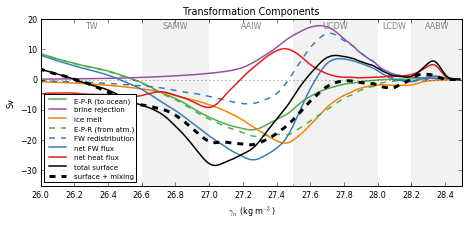

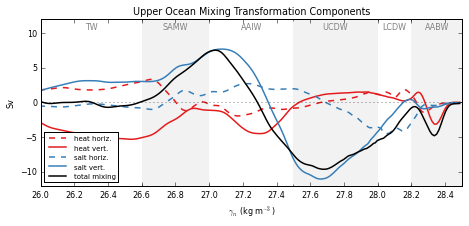

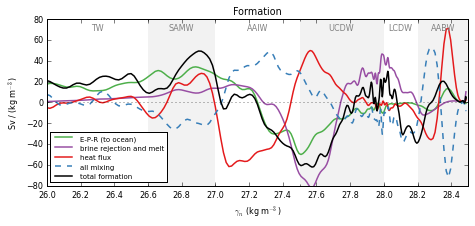

In [15]:
wmt_surface_plot(wmt_gam, '../figures_ice_moc/transformation_surface_gamman.pdf',
          r'$\gamma_n$ (kg m$^{-3}$)', np.arange(26,28.51,0.2),
          wmass_names_gam, wmass_vals_gam);

wmt_mixing_plot(wmt_gam, '../figures_ice_moc/transformation_mixing_gamman.pdf',
          r'$\gamma_n$ (kg m$^{-3}$)', np.arange(26,28.51,0.2),
          wmass_names_gam, wmass_vals_gam);

formation_plot(wmf_gam, '../figures_ice_moc/formation_gamman.pdf',
          r'$\gamma_n$ (kg m$^{-3}$)', np.arange(26,28.51,0.2),
          wmass_names_gam, wmass_vals_gam);


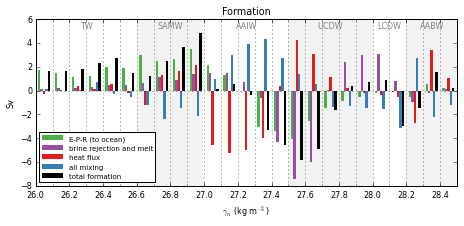

In [16]:
formation_bar_plot(wmf_gam, '../figures_ice_moc/formation_gamman_bar.pdf',
          r'$\gamma_n$ (kg m$^{-3}$)', np.arange(26,28.51,0.2),
          wmass_names_gam, wmass_vals_gam);


## Temporal Variability ##

In [17]:
ds_ice = xray.open_dataset('../data/ice_in_rho_space.nc')
ds_ice['gamman'] = ds.gamman
ds_ice.set_coords('gamman', inplace=True)

<xray.Dataset>
Dimensions:        (sigma0: 399, time: 438)
Coordinates:
  * sigma0         (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 22.68 ...
  * time           (time) datetime64[ns] 2005-01-06T05:00:00 ...
    gamman         (sigma0) float64 25.83 25.83 25.83 25.83 25.83 25.83 ...
Data variables:
    heff           (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    concentration  (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    outcrop_area   (time, sigma0) float64 4.745e+08 2.369e+08 4.845e+08 ...

In [18]:
ds_ice = ds_ice.swap_dims({'sigma0': 'gamman'})
ds_gam = ds.swap_dims({'sigma0': 'gamman'})

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


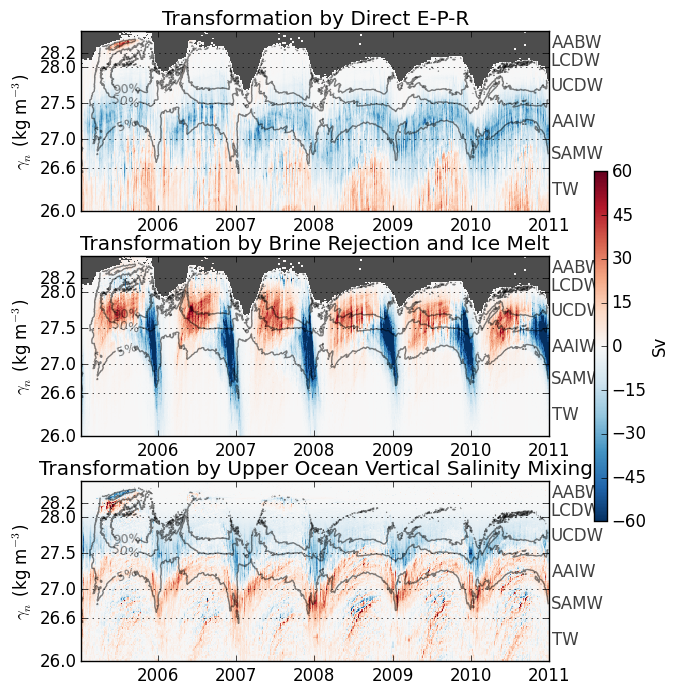

In [19]:
show_heat = False
ds_plt = ds_gam

if show_heat:
    nrows=4
    hspace=0.32
else:
    nrows=3
    hspace=0.25

plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

fig, axes = plt.subplots(nrows=nrows, subplot_kw={'axisbg': '0.3'}, figsize=(6.5,7.))

mask = (ds_ice.outcrop_area>1e9)

plt.subplots_adjust(left=0.1, bottom=0.05, right=0.82, top=0.95, hspace=hspace)
plot_kwargs = dict(vmin=-60, vmax=60, cmap='RdBu_r',
                   add_colorbar=False, rasterized=True)


Tlab = pd.to_datetime(ds.time[40].data).toordinal()

### Atm to Ocean ###
(ds_plt.salt_AO.where(mask).T).plot(ax=axes[0], **plot_kwargs)
### Ice to Ocean ###
(ds_plt.salt_IO.where(mask).T).plot(ax=axes[1], **plot_kwargs)
### Heat Flux ###
if show_heat:
    (ds_plt.heat_flux.where(mask).T).plot(ax=axes[2], **plot_kwargs)
### Mixing
pc = ((ds_plt.salt_vdiff + ds_plt.salt_kpp).T).plot(ax=axes[nrows-1], **plot_kwargs)

for ax in axes:
    c = (ds_ice.concentration.where(mask).T*100).plot.contour(ax=ax,
                levels=[5,50,90], colors='k', linewidth=0.25, alpha=0.5,
                add_colorbar=False)
    plt.clabel(c, fmt='%2.0f%%', manual=[(Tlab, 27.2),(Tlab, 27.6),(Tlab, 27.8)],
          fontsize=9, inline_spacing=3)
    #ax.set_ylim([26.0,28])
    ax.set_yticks(np.arange(26,28.51,0.2))
    ax.set_ylim([26,28.5])
    #ax.set_ylabel(r'$\sigma_\theta$')
    ax.set_ylabel(r'$\gamma_n$ (kg m$^{-3}$)')
    ax.set_xlabel('')
    
    #ax.set_xticks(coord_ticks, minor=False);
    ax.set_yticks(wmass_vals_gam[:-1]) #, minor=True);
    #ax.set_yticks([0], minor=True)
    
    ax.grid()
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    for n, (name, dlow, dhigh) in enumerate(zip(
            wmass_names_gam, wmass_vals_gam[:-1], wmass_vals_gam[1:])):
        xmax = ax.get_xlim()[-1]+15
        ax.text(xmax, (dlow+dhigh)/2, name, color='0.25',
                ha='left', va='center', rotation='horizontal')


axes[0].set_title('Transformation by Direct E-P-R')
axes[1].set_title('Transformation by Brine Rejection and Ice Melt')
if show_heat:
    axes[2].set_title('Transformation by Surface Heat Flux')
axes[nrows-1].set_title('Transformation by Upper Ocean Vertical Salinity Mixing')

cbax = fig.add_axes([0.89,0.25,0.02,0.5])
cb = plt.colorbar(pc, cax=cbax)
cb.set_label('Sv')

if show_heat:
    fig.savefig('../figures_ice_moc/fw_transformation_timeseries_gamma_with_heat.pdf')
else:
    fig.savefig('../figures_ice_moc/fw_transformation_timeseries_gamma.pdf')    

## Freshwater Flux in Density Coords ##

In [20]:
ds_fw = []
ds_fw = xray.open_dataset('../data/fw_flux_dens_coords.nc')
ds_fw['gamman'] = xray.DataArray(gam-1000, dims=ds_fw.sigma0.dims, coords=ds_fw.sigma0.coords)
ds_fw.set_coords('gamman', inplace=True)

<xray.Dataset>
Dimensions:     (sigma0: 399, time: 438)
Coordinates:
  * sigma0      (sigma0) float64 22.53 22.55 22.58 22.6 22.63 22.65 22.68 ...
  * time        (time) datetime64[ns] 2005-01-06T05:00:00 ...
    gamman      (sigma0) float64 25.83 25.83 25.83 25.83 25.83 25.83 25.83 ...
Data variables:
    IO_plus_AO  (time, sigma0) float64 -1.001e+06 -6.463e+05 -1.107e+06 ...
    AI_plus_AO  (time, sigma0) float64 -1.001e+06 -6.463e+05 -1.107e+06 ...
    AI          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    AO          (time, sigma0) float64 -1.001e+06 -6.463e+05 -1.107e+06 ...
    IO          (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    IO_brine    (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    IO_melt     (time, sigma0) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    drho        (sigma0) float64 0.025 0.025 0.025 0.025 0.025 0.025 0.025 ...

In [21]:
# take a time mean of everythong
ds_fw_mean = ds_fw.mean(dim='time')

# bin spacing
drho = np.diff(ds_fw.sigma0.values)

fw_ice_dens_flux = np.cumsum(
    (ds_fw_mean.drho*
        (ds_fw_mean.IO - ds_fw_mean.AI).values
    )[::-1]
    )[::-1]

ds_fw_mean['fw_ice_flux'] = xray.DataArray(
    fw_ice_dens_flux, dims=ds_fw_mean.IO.dims, coords=ds_fw_mean.IO.coords
)

In [22]:
fw_atm_dens_flux = np.cumsum(
    (ds_fw_mean.drho*
        (ds_fw_mean.AI_plus_AO).values
    )[::-1]
    )[::-1]

ds_fw_mean['fw_atm_flux'] = xray.DataArray(
    fw_atm_dens_flux, dims=ds_fw_mean.IO.dims, coords=ds_fw_mean.IO.coords
)

In [23]:
ds_fw_gam = ds_fw_mean.swap_dims({'sigma0': 'gamman'})

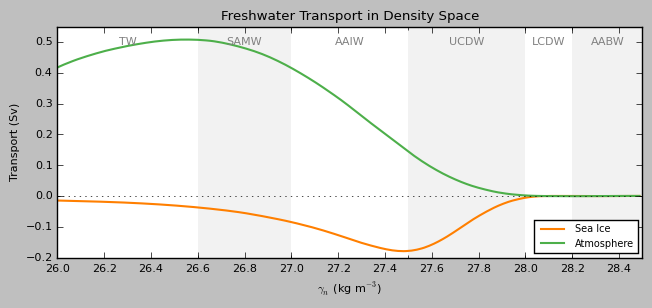

In [24]:
m3_per_kg = 1e-3

fig, ax = base_figure(r'$\gamma_n$ (kg m$^{-3}$)', np.arange(26,28.51,0.2),
          wmass_names_gam, wmass_vals_gam, [-0.2, 0.55], 0.5)
#fig.set_figwidth(4)

mcols = bmap.mpl_colors
(-m3_per_kg * ds_fw_gam.fw_ice_flux / 1e6).plot(ax=ax, color=mcols[4])
(-m3_per_kg * ds_fw_gam.fw_atm_flux / 1e6).plot(ax=ax, color=mcols[2])

ax.set_xlabel(r'$\gamma_n$ (kg m$^{-3}$)')
ax.set_ylabel('Transport (Sv)')
ax.set_title('Freshwater Transport in Density Space')
ax.set_xlim([26,28.5])


ax.legend(['Sea Ice','Atmosphere'], loc='lower right')
plt.savefig('../figures_ice_moc/fw_transport_gamman.pdf')

In [25]:
ax.bar?

In [26]:
wmf_gam

<xray.Dataset>
Dimensions:          (gamman: 398)
Coordinates:
  * gamman           (gamman) float64 25.83 25.83 25.83 25.83 25.83 25.83 ...
    delta_gamman     (gamman) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Data variables:
    heat_wthmass     (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_IO_plus_AO  (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_AI_plus_AO  (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_AI          (gamman) float64 inf -inf -inf -inf -inf inf inf inf ...
    salt_AO          (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_IO          (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_IO_brine    (gamman) float64 -inf -inf -inf inf inf inf -inf -inf ...
    salt_IO_melt     (gamman) float64 inf inf inf inf inf inf inf inf inf ...
    salt_wsltmass    (gamman) float64 -inf -inf -inf -inf -inf -inf -inf ...
    salt_surfflux    (gamman) float64 inf inf inf inf inf inf i